# **Sentiment Analysis for Product Reviews**

<div style="text-align:center;">
    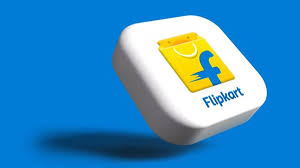
</div>

## Project Overview
This project aims to develop a sentiment analysis model to classify customer reviews from Flipkart into neutral, positive, or negative sentiments. Leveraging machine learning techniques, the model will analyze textual reviews and assign appropriate sentiment labels to each review.Flipkart is a leading e-commerce platform in India, offering a wide range of products across categories like mobiles, fashion, electronics, home appliances, groceries, and more. It provides a convenient and secure online shopping experience with features like cash on delivery, easy returns, and multiple payment options.

## Business Understanding
Understanding customer sentiment is crucial for businesses to gauge product reception, identify areas of improvement, and tailor marketing strategies. By analyzing customer reviews, businesses can gain valuable insights into customer satisfaction levels, product strengths, and weaknesses. This sentiment analysis project will provide actionable intelligence to enhance customer experience and product offerings.

## Business Problem
Despite the abundance of customer reviews, manually analyzing and categorizing sentiments is time-consuming and impractical at scale. Automated sentiment analysis can streamline this process, enabling businesses to efficiently process large volumes of reviews and derive meaningful insights.

### Objectives:
* Develop a robust sentiment analysis model capable of accurately categorizing customer reviews into neutral, positive, or negative sentiments.
- Sentiment Analysis and text data analysis to derive insights from it
* Enhance efficiency by automating the sentiment analysis process, reducing manual effort and time required for review analysis.
* Provide actionable insights to stakeholders for informed decision-making, such as product improvements, marketing strategies, and customer engagement tactics.
* Deploy the sentiment analysis model

## Data Understanding 
The data is obtained from Kaggle: [Flipkart Product reviews with sentiment Dataset](https://www.kaggle.com/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset).The dataset consists of customer reviews sourced from Flipkart, a prominent Indian e-commerce platform.

Data Columns:   
  
`` Product_name:`` Name of the product.  
`` Product_price:``Price of the product.  
``Rate:`` Customer's rating on product(Between 1 to 5).  
``Review:`` Customer's review on each product.   
``Summary:`` This column include descriptive informationn of customer's thought on each product.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class DataProcessor:
    def __init__(self, df):
        # Initialize with a DataFrame.
        self.df = df

    def get_info(self):
        # Get basic DataFrame info 
        return self.df.info()
    
    def get_summary_statistics(self):
        # Get summary statistics for numerical columns.
        return self.df.describe()
    
    def get_dtypes(self):
        # Get data types of columns.
        return self.df.dtypes
    
    def get_missing_values(self):
        # Get the count of missing (null) values in each column.
        return self.df.isnull().sum()

    def get_shape(self):
        # Get data types of columns.
        return self.df.shape
        

In [3]:
# load and preview the dataset
data = pd.read_csv('Dataset-SA.csv')
data.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [4]:
# Initialize the DataProcessor class
dp = DataProcessor(data)

In [5]:
#information about the dataset
dp.get_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


In [6]:
# Check Data Dimensions
dp.get_shape()

(205052, 6)

In [7]:
# check the datatypes
dp.get_dtypes()

product_name     object
product_price    object
Rate             object
Review           object
Summary          object
Sentiment        object
dtype: object

## Data Preparation

In [8]:
# Convert 'Rate' column to numeric, coercing errors to NaN
data['Rate'] = pd.to_numeric(data['Rate'], errors='coerce')


#### Check for missing values

In [9]:
# check for missing values
dp.get_missing_values()

product_name         0
product_price        0
Rate                 3
Review           24664
Summary             11
Sentiment            0
dtype: int64

#### Dealing with missing values

In [10]:
# dropping the rows with content missing values
data.dropna(subset = ['Review', 'Summary', 'Rate'],inplace=True)

#### Check for duplicates and drop it

In [11]:
# Count the total number of duplicate rows
total_duplicates = data[data.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 25912


In [12]:
# Drop duplicate rows
data.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
data.reset_index(drop=True, inplace=True)

#### Combine review and summary column
both columns contains the sentiments of the customers

In [13]:
data['Summary'] = data['Summary'].apply(str)
data['Review']= data['Review'].astype(str)

In [14]:
data['Review_Text']= data[['Summary','Review']].agg(' '.join,axis=1)


In [15]:
# drop summary and Review column
data.drop(['Summary','Review'],axis=1,inplace=True)
data.head()

,product_name,product_price,Rate,Sentiment,Review_Text
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5.0,positive,great cooler excellent air flow and for this p...
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5.0,positive,best budget 2 fit cooler nice cooling awesome
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3.0,positive,the quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1.0,negative,very bad product its a only a fan useless product
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3.0,neutral,ok ok product fair


## Exploratory Data Analysis


#### Sentiment distribution analysis

In [16]:
data.Sentiment.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [17]:
data.Sentiment.value_counts()

positive    122806
negative     23352
neutral       8306
Name: Sentiment, dtype: int64

In [18]:
# Set the default style to 'dark_background'
plt.style.use('dark_background')

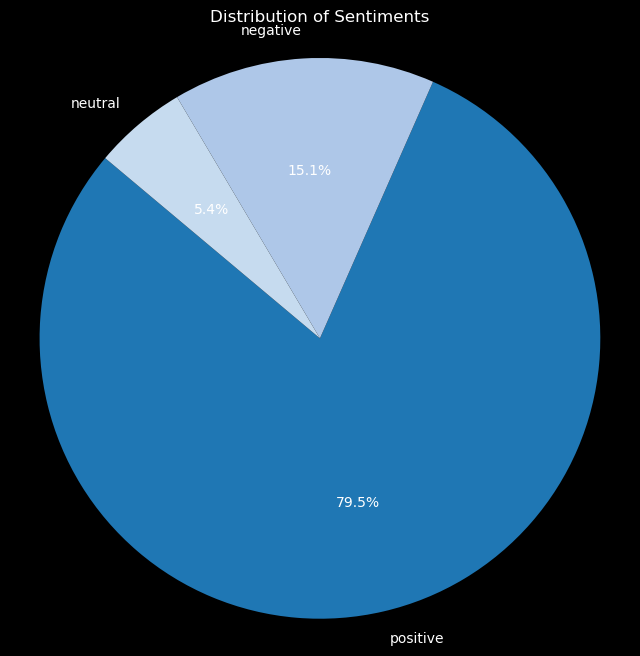

In [19]:
# Calculate the distribution of sentiments
sentiment_distribution = data['Sentiment'].value_counts()

# Define shades of blue
colors = ['#1f77b4', '#aec7e8', '#c6dbef']
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

plt.show()

**Insights:**

Sentiment Distribution Summary

- **Neutral Sentiment:** Approximately 5.4% of sentiments are neutral.
- **Negative Sentiment:** About 15.1% of sentiments are negative.
- **Positive Sentiment:** Around 79.5% of sentiments are positive.

The sentiment distribution is not balanced with positive sentiment being the most common.This suggest that most of the  product bought from flipkart have good reviews.

#### Distribution of Rate

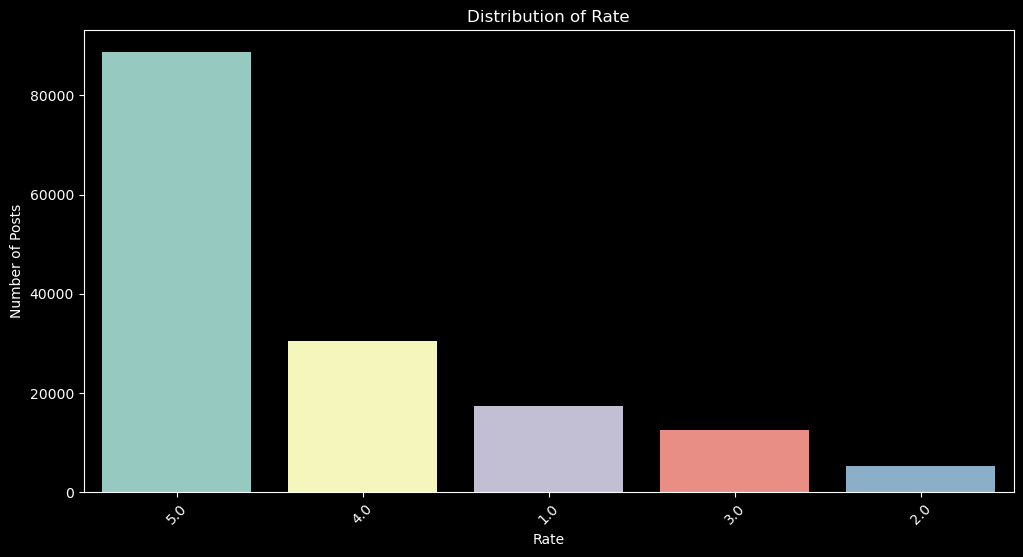

In [20]:

# Univariate analysis of 'Entity' column
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Rate', order=data['Rate'].value_counts().index)
plt.xticks(rotation=45)
plt.xlabel('Rate')
plt.ylabel('Number of Posts')
plt.title('Distribution of Rate')
plt.show();


**Insights:**  
Rate of 5 has the highest count indicating most people rated the products 5 

### Sentiments Across Different Customer Ratings

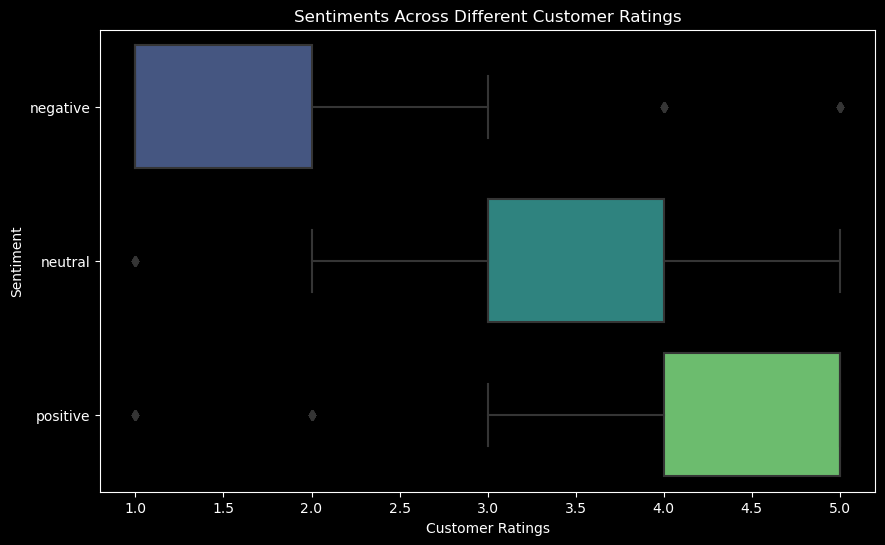

In [21]:
# Plot sentiments against customer ratings (Rate)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rate', y='Sentiment', data=data, order=['negative', 'neutral', 'positive'], palette='viridis')
plt.title('Sentiments Across Different Customer Ratings')
plt.xlabel('Customer Ratings')
plt.ylabel('Sentiment')
plt.show()

The box plot shows the distribution of sentiments (negative, neutral, positive) within each customer rating category (Rate)

**Insights:** 
* Negative Sentiment: Corresponds to customer ratings between 1 and 2.
* Neutral Sentiment: Corresponds to customer ratings between 3 and 4.
* Positive Sentiment: Corresponds to customer ratings above 4.

### Text Analysis with NLP Preprocessing
The objective of this section is to perform NLP preprocessing on the text data in order to prepare it for further analysis

The code below will: 
* Removed special characters, numbers, and links from the text.
* Converted text to lowercase.
* Tokenized the text into words.
* Removed stopwords  
* lemmatization

In [22]:
# Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
data['Cleaned_Review'] = data['Review_Text'] .apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Sentiment Analysis 

To perform sentiment analysis, I'll use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from NLTK

In [49]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the cleaned content
data['Sentiment_Scores'] = data['Cleaned_Review'].apply(get_sentiment_scores)

# Extract sentiment scores into separate columns
data['Positive_Score'] = data['Sentiment_Scores'].apply(lambda x: x['pos'])
data['Neutral_Score'] = data['Sentiment_Scores'].apply(lambda x: x['neu'])
data['Negative_Score'] = data['Sentiment_Scores'].apply(lambda x: x['neg'])
data['Compound_Score'] = data['Sentiment_Scores'].apply(lambda x: x['compound'])


### Sentiment Scores by Sentiment

This code  demonstrates how to create a visualization to compare sentiment scores (positive, neutral, and negative) across different sentiment categories (Negative, Neutral, Positive) in the dataset.


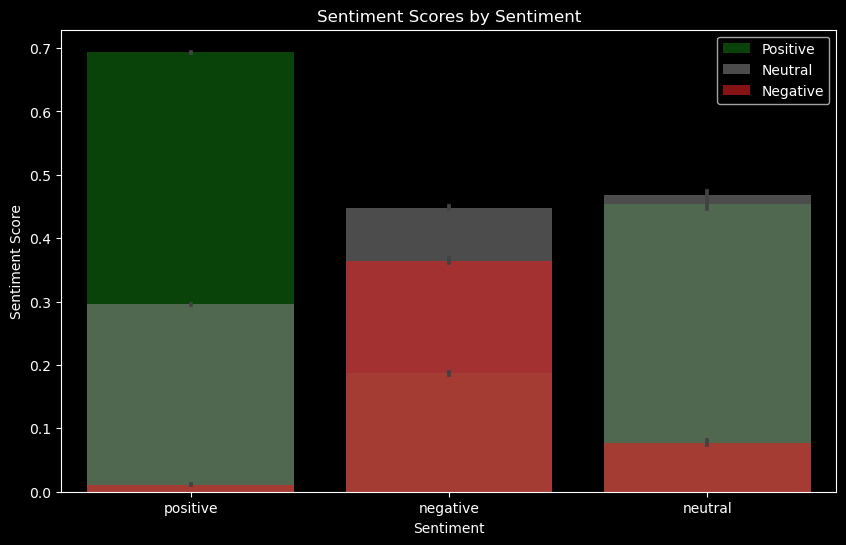

In [24]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot positive sentiment scores
sns.barplot(x=data['Sentiment'], y=data['Positive_Score'], color='green', alpha=0.6, label='Positive')

# Plot neutral sentiment scores
sns.barplot(x=data['Sentiment'], y=data['Neutral_Score'], color='grey', alpha=0.6, label='Neutral')

# Plot negative sentiment scores
sns.barplot(x=data['Sentiment'], y=data['Negative_Score'], color='red', alpha=0.6, label='Negative')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores by Sentiment')
plt.legend()

# Show the plot
plt.show()


### Interpretation:

The resulting bar plot visually depicts the distribution of sentiment scores across different sentiment categories. It provides insights into the sentiment distribution for each sentiment type, enabling us to identify patterns and trends in sentiment scores associated with different sentiments.

* The visualization provides a snapshot of the overall sentiment distribution in the dataset, highlighting the predominance of positive sentiments.
* This suggests that the majority of customers are likely satisfied or have positive experiences with the products offered on Flipkart.

### Text Data Analysis

#### Review Text Length Analysis

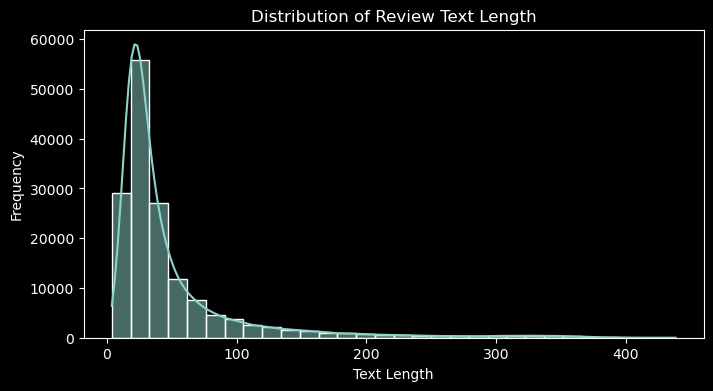

In [25]:
# for text length analysis
data['Review_Length'] = data['Cleaned_Review'].str.len()  # Calculate text length
plt.figure(figsize=(8, 4))
sns.histplot(data['Review_Length'], bins=30, kde=True)
plt.title("Distribution of Review Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

**Insights:** 
* Peak at Short reviews: The histogram shows that there is a peak in the frequency of short reviews. Many reviews are relatively brief in terms of character count. 
* Longer reviews exist: While short reviews are prevalent, there is still a range of longer reviews present in the dataset, as evidenced by the right tail of the distribution.

#### Word Frequency Analysis

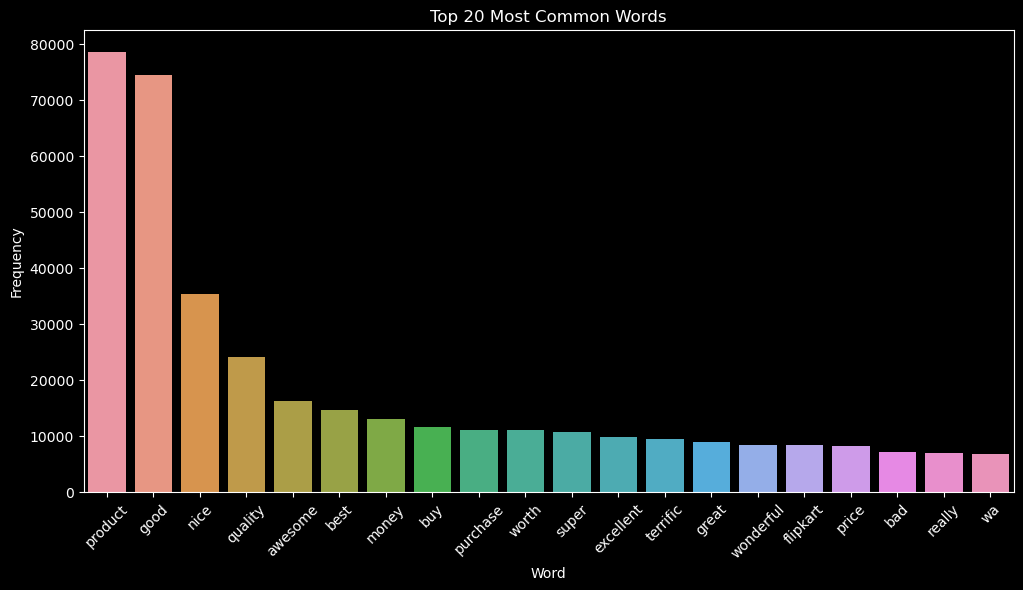

In [26]:
# word frequency analysis
from collections import Counter

words = ' '.join(data['Cleaned_Review']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Plot the top N most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


**Insights:** 
- **Relevant Keywords:** The most common words now primarily consist of relevant keywords specific to the content since stopwords was removed. Th most frequent word is Product. 

### Word Cloud of Lemmatized Review Text

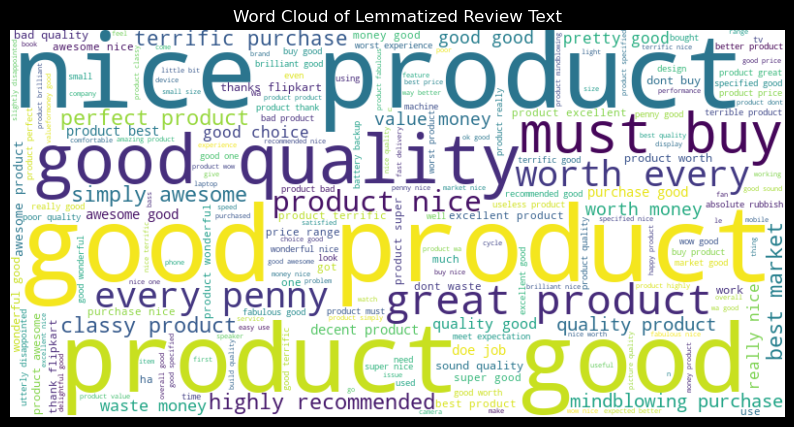

In [27]:
# Join the lemmatized content into a single string
text_data_lemmatized = ' '.join(data['Cleaned_Review'].dropna())
# Generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)
# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Review Text")
plt.show()

- **Word Cloud Visualization:** The word cloud above visually represents the most frequently occurring words in the lemmatized review text.
- **Word Size:** The size of each word in the cloud corresponds to its frequency in the text data.    

**Insights:**
- **Prominent Keywords:** The word cloud highlights the most prominent keywords in the lemmatized content. In this case, words like product," "good," "nice," "great," and "quality" appear prominently.
- **Keyword Emphasis:** The larger the word in the cloud, the more frequently it occurs in the text data.


### Word Cloud of Positive Review

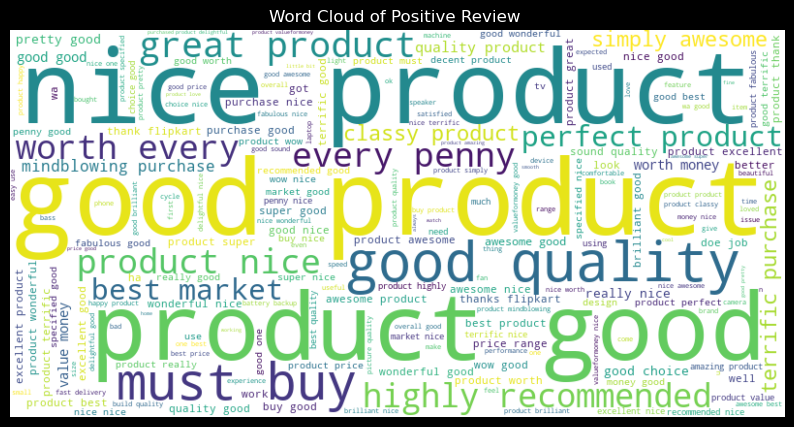

In [28]:
# Filter data for positive sentiment
positive_data = data[data['Sentiment'] == 'positive']

# Combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Cleaned_Review'].dropna())

# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Review ")
plt.show()


**Insights:**  
- **Prominent Positive Keywords:** The word cloud prominently displays positive keywords.The most prominent words are "product", "Good", "nice", "great" etc  
The word cloud provides a visual representation of the prevalent themes or topics that evoke positive sentiment among users. These themes may include positive reviews, endorsements, praise, or expressions of satisfaction.

- **Keyword Importance:** By identifying the most common positive keywords, organizations can gain insights into what  product resonate positively with their customers. This information can inform marketing strategies and product analysis.

- **Engagement Opportunities:** Recognizing the positive sentiment keywords allows organizations to engage with customers who liked their products. This engagement can further strengthen product loyalty and foster positive relationships with customers.

### Word Cloud of Negative Sentiment

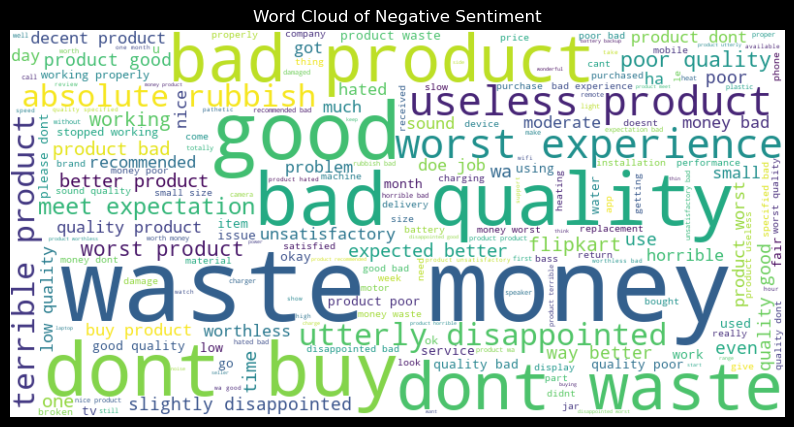

In [29]:
# Filter data for negative sentiment
negative_data = data[data['Sentiment'] == 'negative']

# Combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Cleaned_Review'].dropna())

# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment")
plt.show()

**Insights:**   
-  **Negative Themes:** The word cloud provides a visual representation of the prevalent products  that evoke negative sentiment among customers . In this case, texts like "money," "bad," "don't", '"waste" are associated with negative reviews
- **Keyword Importance:** Identifying the most common negative keywords is crucial for understanding what aspects of a product,  are driving negative sentiment. This information can guide improvement efforts and issue resolution.
- **User Feedback:** Recognizing the negative sentiment keywords allows organizations to engage with customers who express negative opinions. Responding to and resolving negative feedback can improve product perception and customer satisfaction.

### Word Cloud of Neutral Sentiment

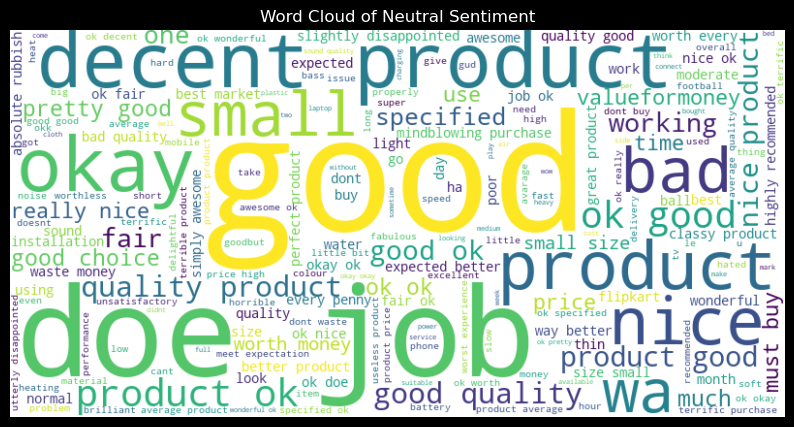

In [30]:
# Filter data for neutral sentiment
neutral_data = data[data['Sentiment'] == 'neutral']

# Combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Cleaned_Review'].dropna())

# Generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment")
plt.show()


**Insights:** 
- **Neutral Themes:** The word cloud provides a visual representation of the prevalent words that shows neutrality by users. In this case, words like "good," "decent," and "okay" are notable as they contribute to a sense of neutrality.

## Data Preprocessing

Sampling of the data for machine learning training

In [31]:
# Filter out 8000 rows for each sentiment category
positive_data = data[data['Sentiment'] == 'positive'].head(8000)
negative_data = data[data['Sentiment'] == 'negative'].head(8000)
neutral_data = data[data['Sentiment'] == 'neutral'].head(8000)

# Concatenate the filtered dataframes
data = pd.concat([positive_data, negative_data, neutral_data])

# Display the first few rows of the sampled data
data.Sentiment.value_counts()

positive    8000
negative    8000
neutral     8000
Name: Sentiment, dtype: int64

### Data Splitting
Assign the variables for machine learning.assigning y/ target variable to sentiment feature for classification and and the review feature to independent variable X

In [32]:
# Assign the variables
X = data['Cleaned_Review']  # Features
y = data['Sentiment']  # Target
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Feature Extraction (Vectorization)
convert text data into numerical features that can be used by machine learning algorithms using TF-IDF vectorization

In [33]:

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [34]:
print('X_Train shape after vectorization:', X_train_tfidf.shape)
print('X_Test shape after vectorization:', X_test_tfidf.shape)

X_Train shape after vectorization: (19200, 10000)
X_Test shape after vectorization: (4800, 10000)


### Smote analysis to deal with class imbalance

In [35]:
y_train.value_counts()

negative    6408
positive    6405
neutral     6387
Name: Sentiment, dtype: int64

SMOTE (Synthetic Minority Over-sampling Technique) s specifically designed to handle the imbalanced distribution of the target variable, where the minority class has significantly fewer samples compared to the majority class.  

I will use smote to resolve the imbalance in the target variables although the difference is not much.

In [36]:
from imblearn.over_sampling import SMOTE

In [37]:
#instantiate SMOTE 
sm = SMOTE(k_neighbors=5, random_state=123)
# fit sm on the training data
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_tfidf, y_train)
# print training data set before over sampling
print('Before resampling, the shape of X_train: {}'.format(X_train_tfidf.shape))
print('Before resampling, the shape of y_train: {}'.format(y_train.shape)) 
# print training data set after over sampling
print('After resampling, the shape of X_train_resampled: {}'.format(X_train_resampled.shape))
print('After resampling, the shape of y_train_resampled: {}'.format(y_train_resampled.shape))
y_train_resampled.value_counts()

Before resampling, the shape of X_train: (19200, 10000)
Before resampling, the shape of y_train: (19200,)
After resampling, the shape of X_train_resampled: (19224, 10000)
After resampling, the shape of y_train_resampled: (19224,)


positive    6408
neutral     6408
negative    6408
Name: Sentiment, dtype: int64

## MODELING

### Baseline Model: Logistic Regression
Logistic regression is commonly used in sentiment analysis to classify text data into categories such as neutral, positive, and negative sentiments.Logistic regression is favored in sentiment analysis for its simplicity, efficiency, and ability to handle large feature spaces. Additionally, its probabilistic output is useful for understanding the confidence of the predictions, which can be particularly valuable in applications requiring nuanced sentiment interpretation.

In [38]:
# Initialize the model
model = LogisticRegression(max_iter=10000, solver='liblinear')

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_test = model.predict(X_test_tfidf)
y_pred_train = model.predict(X_train_resampled)

#### Model Evaluation

In [39]:
# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Train Accuracy:", accuracy_score(y_train_resampled, y_pred_train))

print(classification_report(y_test, y_pred_test))

Test Accuracy: 0.8322916666666667
Train Accuracy: 0.8735955056179775
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      1592
     neutral       0.83      0.72      0.77      1613
    positive       0.82      0.93      0.87      1595

    accuracy                           0.83      4800
   macro avg       0.83      0.83      0.83      4800
weighted avg       0.83      0.83      0.83      4800



TThe logistic regression model achieves an accuracy of 83.22% on the test data, with slightly lower performance on the "neutral" class compared to the other classes.There is no significance difference between test and train accuracy

### Support Vector Machine (SVM) model
SVM models are powerful tools for sentiment analysis, offering robustness and effectiveness, especially when dealing with complex and high-dimensional text data.

In [40]:
from sklearn.svm import SVC

# Initialize the model
svm_model = SVC(kernel='poly', random_state=42)

# Train the model
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set and train set
y_pred_svm_test = svm_model.predict(X_test_tfidf)
y_pred_svm_train = svm_model.predict(X_train_resampled)

#### Model Evaluation

In [41]:
# Evaluate the model
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm_test))
print("SVM Train Accuracy:", accuracy_score(y_train_resampled, y_pred_svm_train))

print(classification_report(y_test, y_pred_svm_test))

SVM Test Accuracy: 0.8177083333333334
SVM Train Accuracy: 0.9734706616729089
              precision    recall  f1-score   support

    negative       0.82      0.86      0.84      1592
     neutral       0.84      0.67      0.75      1613
    positive       0.80      0.92      0.86      1595

    accuracy                           0.82      4800
   macro avg       0.82      0.82      0.81      4800
weighted avg       0.82      0.82      0.81      4800



The SVM model achieves a test accuracy of 81.77%, which is lower than the logistic regression model's accuracy. However, the precision, recall, and F1-score for each class are comparable between the two models.when considering overfitting, the logistic regression model shows signs of  less overfitting compared to the SVM model

### Random Forest Model
Random Forest is a versatile and powerful ensemble learning method that is well-suited for classification tasks, including sentiment analysis.Random Forests offer a robust and effective approach for sentiment analysis, leveraging the power of multiple decision trees to improve prediction accuracy and generalization

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_rf_test = rf_model.predict(X_test_tfidf)
y_pred_rf_train = rf_model.predict(X_train_resampled)

#### Model Evaluation

In [43]:
# Evaluate the model
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf_test))
print("Random Forest Train Accuracy:", accuracy_score(y_train_resampled, y_pred_rf_train))

print(classification_report(y_test, y_pred_rf_test))

Random Forest Test Accuracy: 0.809375
Random Forest Train Accuracy: 0.9829379941739492
              precision    recall  f1-score   support

    negative       0.84      0.81      0.83      1592
     neutral       0.78      0.71      0.74      1613
    positive       0.81      0.91      0.85      1595

    accuracy                           0.81      4800
   macro avg       0.81      0.81      0.81      4800
weighted avg       0.81      0.81      0.81      4800



The Random Forest model achieves a test accuracy of approximately 80.9%, with a train accuracy of about 98.3%. In terms of precision, recall, and F1-score for each class, it generally performs well, showing slightly lower performance in the 'neutral' class compared to logistic regression and SVM.Random Forest demonstrates competitive performance, but its higher train accuracy suggests a potential for overfitting compared to logistic regression and SVM.

### Model Comparison

Considering both test accuracy and the overall performance in precision, recall, and F1-score, logistic regression seems to be the best-performing model among the three. It also has relatively good train accuracy, suggesting it may generalize well to unseen data. Thus, logistic regression might be a good candidate for further hyperparameter tuning and deployment.

### Tuned Logistic Regression

In [44]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Initialize the logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Perform grid search to find the best parameters
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to train the final model
best_model = LogisticRegression(random_state=42, max_iter=1000, **best_params)
best_model.fit(X_train_resampled, y_train_resampled)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}


LogisticRegression(C=1, max_iter=1000, random_state=42, solver='saga')

In [45]:
# Evaluate the model
y_pred_test = best_model.predict(X_test_tfidf)
y_pred_train = best_model.predict(X_train_resampled)

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Train Accuracy:", accuracy_score(y_train_resampled, y_pred_train))
print(classification_report(y_test, y_pred_test))


Test Accuracy: 0.839375
Train Accuracy: 0.8905534748231377
              precision    recall  f1-score   support

    negative       0.86      0.85      0.85      1592
     neutral       0.83      0.74      0.78      1613
    positive       0.83      0.93      0.88      1595

    accuracy                           0.84      4800
   macro avg       0.84      0.84      0.84      4800
weighted avg       0.84      0.84      0.84      4800



The tuned logistic regression model exhibits strong performance, with a test accuracy of approximately 83.94% and a train accuracy of around 89.06%. This indicates that the model generalizes well to unseen data without significant overfitting.the model's balanced performance across different sentiment classes and its ability to maintain high accuracy on both the training and test sets make it a suitable choice for sentiment analysis tasks.

## Deployment

In [46]:
import pickle

In [47]:
# Now let's pickle the model
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [48]:
# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

## Recommendations


- Leveraging Positive Keywords for Product Insights:
By discerning the most frequently occurring positive keywords, organizations can uncover valuable insights into which products resonate positively with their customer base. This knowledge serves as a foundation for refining marketing strategies and conducting in-depth product analysis.

- Enhancing Customer Engagement through Positive Sentiment Recognition:
Recognizing positive sentiment keywords empowers organizations to actively engage with customers who have expressed satisfaction with their products. This proactive engagement not only reinforces product loyalty but also nurtures positive relationships with customers, fostering long-term brand advocacy.

- Utilizing Negative Keywords for Product Improvement:
Identifying prevalent negative keywords is pivotal in comprehending the specific aspects of a product that drive negative sentiment among consumers. This actionable intelligence serves as a roadmap for targeted improvement efforts and effective issue resolution, ultimately enhancing product quality and customer satisfaction.

- Addressing Negative Feedback for Improved Perception:
By acknowledging negative sentiment keywords, organizations can effectively engage with customers who have voiced concerns or dissatisfaction. Timely response and resolution of negative feedback not only mitigate potential damage but also demonstrate a commitment to customer satisfaction, positively influencing overall product perception.

- Harnessing Sentiment Analysis for Predictive Insights:
Leveraging the sentiment analysis model,Flipkart can automate the prediction of a vast number of reviews. This predictive capability enables tailored feedback mechanisms and empowers the development of targeted marketing strategies, tailored to meet the evolving needs and preferences of their customer base.

- Using the deployed Sentiment Analysis App for Review Classification:
The deployment of a sentiment analysis application enables the efficient prediction and classification of reviews into neutral, positive, or negative sentiments. This intuitive tool not only streamlines the review analysis process but also facilitates data-driven decision-making, empowering organizations to proactively address customer feedback and enhance overall customer experience.

## conclusion
- The project successfully developed a sentiment analysis model to classify customer reviews of products as positive, negative or neutral
- By leveraging the insights gained from exploratory data analysis and sentiment analysis model ,stakeholders can effectively classify the sentiments from the customers and make the necessary improvements.
